In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import random
import scipy
from sympy import *
import torch as tr
import subprocess

3765 3765 3765


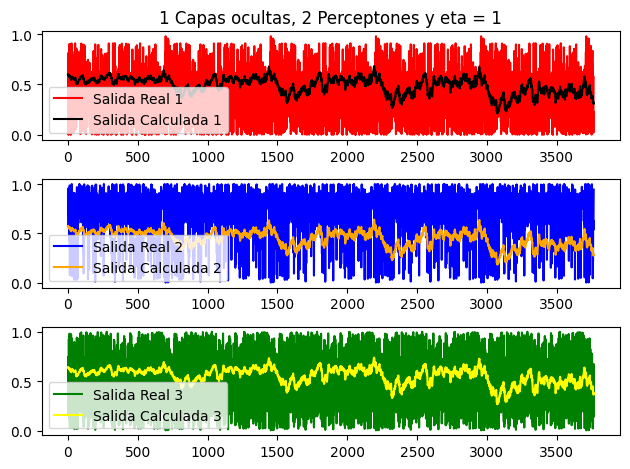

In [258]:
def sig(aux):
    return 1/(1 + np.exp(-aux))

def sig_der(aux):
    return np.exp(-aux)/((1+np.exp(-aux))**2)

def tanh(aux):
    return (np.exp(aux)-np.exp(-aux))/(np.exp(aux)+np.exp(-aux))

def tanh_der(aux):
    return 1 - ((np.exp(aux)-np.exp(-aux))/(np.exp(aux)+np.exp(-aux)))**2

def fun_activ(a, b, aux, fun: str):
    if fun == "lin":
        phi = a*aux + b
    elif fun == "sigm":
        phi = sig(a*aux) + b
    elif fun == "tanh":
        phi = tanh(a*aux) + b
    else:
        return print("La funcion no esta considerada")
    return phi

def fun_der(a, b, aux, fun: str):
    if fun == "lin":
        aux[:, 0] = 1
        phi = aux
    elif fun == "sigm":
        phi = sig_der(a*aux) + b
    elif fun == "tanh":
        phi = tanh_der(a*aux) + b
    else:
        return print("La funcion no esta considerada")
    return phi

def tam_ent(s):                         #numero de entradas
    aux = np.array([[None]]*s)
    for i in range(s):
        aux[i] = Symbol(f'x{i+1}')
    return aux

def tam_pes(s, t):                 #numero de perceptones antes, numero de perceptones despues
    return np.empty((t, s), float)

#reemplazar los valores en cada matriz de pesos inicialmente
def rem_pes(arr):                  #arreglo de pesos y arreglo con el valor de los respectivos pesos
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = random.random()
    return arr

def rem_ini(arr, aux):
    for i in range(len(arr)):
        arr[i][0] = float(arr[i][0].subs(arr[i][0], aux[i][0]))
    return arr

def percep_mult(n, p, l, m):
    xi = tam_ent(n)
    wi0 = tam_pes(n, p)
    w_aux = []
    for i in range(l):       #numero de capas de ocultas + la inicial
        w_aux.append(tam_pes(p, p))
    aux_fin = np.transpose(tam_pes(p, m))
    return xi, wi0, w_aux, aux_fin

def eva_yk(wi0, wji, wkj, xi, a, b):
    yi = fun_activ(a, b, (wi0 @ xi), 'sigm')
    yj = []
    for i in range(l):
        yj.append(fun_activ(a, b, (wji[i] @ yi), 'sigm'))
    return yi, yj, fun_activ(a, b, (np.transpose(wkj) @ yj[l-1]), 'sigm')


#------------Lectura de base de datos----------------------------------------

mat = scipy.io.loadmat("datos.mat")           #Lectura
arr = np.concatenate((mat['COD1'], mat['Xv1'], mat['t']), axis = 1)    #Concatenar columnas
df = pd.DataFrame(arr)                        #Pasamos a dataframe para operar
df = (df- df.min())/(df.max()-df.min())       #Estandarizamos los datos entre [0, 1]
df = df.drop([0])

df_shuffled = df.sample(frac=1).reset_index(drop=True)

p_train = 0.60                                # Porcentaje de train.
p_test = 0.50                                 # Porcentaje de testeo

df_shuffled['sep'] = np.random.uniform(0, 1, len(df_shuffled)) <= p_train
df_train, df_aux = df_shuffled[df_shuffled['sep']==True], df_shuffled[df_shuffled['sep']==False]
df_train = df_train.drop('sep', axis = 1)
df_aux = df_aux.drop('sep', axis = 1)
df_aux['sep'] = np.random.uniform(0, 1, len(df_aux)) <= p_test
df_test, df_val = df_aux[df_aux['sep']==True], df_aux[df_aux['sep']==False]
df_test = df_test.drop('sep', axis = 1)
df_val = df_val.drop('sep', axis = 1)

arr = df_train
arr = arr.to_numpy().tolist()

eta_aux = [1]
epoc = 5

for et in eta_aux:
    n = len(arr[0])    #Numero de entradas
    p = 2    #Numero de perceptones
    l = 1    #Numero de capas ocultas
    m = len(arr[0])    #Salida
    a = 1
    b = 0
    eta = et
    x_i = arr
    yd = x_i
    AUX = np.asarray(arr)
    grad_i = []
    grad_j = []
    grad_aux = []
    grad_k = []
    y_hist = []
    err_aux = []
    ener = []
    x_aux, wi0, wji, wkj = percep_mult(n, p, l, m)
    wi0 = rem_pes(wi0)
    wji = rem_pes(wji)
    wkj = rem_pes(wkj)

    for j in range(epoc):              #Numero de veces que se le pasaran los datos
        if j > 0:
            AUX = np.concatenate((AUX, np.asarray(arr)))
        for i in range(len(x_i)):
            xi = np.transpose([x_i[i]])
            yi, yj, yk = eva_yk(wi0, wji, wkj, xi, a, b)
            yk_aux = np.transpose(yk)
            err = yd[i] - yk_aux[0]
            err = np.mean(err)
            if abs(err) <= 0.02:
                y_hist.append(yk_aux[0])
                err_aux.append(err)
                ener.append(err**2/2)
                grad_k.append(err*fun_der(a, b, yk, 'sigm'))
                grad_j_aux = []
                if l == 1:
                    grad_aux = fun_der(a, b, yj[l-1], 'sigm')*wkj@grad_k[i]
                    grad_j.append(grad_aux)
                else:
                    grad_aux = fun_der(a, b, yj[l-1], 'sigm')*wkj@grad_k[i]
                    grad_j_aux.append(grad_aux)
                    for j in range(1,l-1):
                        grad_aux = fun_der(a, b, yj[l-j], 'sigm')*wji[l-j-1]@grad_j_aux[j-1]
                        grad_j_aux.append(grad_aux)
                    grad_aux = fun_der(a, b, yj[0], 'sigm')*wji[0]@grad_j_aux[l-2]
                    grad_j_aux.append(grad_aux)
                    grad_j.append(grad_j_aux)
        
                if l == 1:
                    grad_i.append(fun_der(a, b, yi, 'sigm')*wji[0]@grad_j[i])
                else:
                    grad_i.append(fun_der(a, b, yi, 'sigm')*wji[0]@grad_j[i][l-1])
                
                continue
            

            
            y_hist.append(yk_aux[0])
            err_aux.append(err)
            ener.append(err**2/2)
            grad_k.append(err*fun_der(a, b, yk, 'sigm'))
            wkj = wkj + eta*(np.transpose(grad_k[i]@np.transpose(yj[l-1])))
            grad_j_aux = []
            if l == 1:
                grad_aux = fun_der(a, b, yj[l-1], 'sigm')*wkj@grad_k[i]
                grad_j.append(grad_aux)
                wji[0] = wji[0] + eta*(grad_j[i]@np.transpose(yi))
            else:
                grad_aux = fun_der(a, b, yj[l-1], 'sigm')*wkj@grad_k[i]
                grad_j_aux.append(grad_aux)
                wji[0] = wji[0] + eta*(grad_j_aux[0]@np.transpose(yj[l-1]))
                for j in range(1,l-1):
                    grad_aux = fun_der(a, b, yj[l-j], 'sigm')*wji[l-j-1]@grad_j_aux[j-1]
                    grad_j_aux.append(grad_aux)
                    wji[0] = wji[0] + eta*(grad_j_aux[j]@np.transpose(yj[l-j-1]))
                grad_aux = fun_der(a, b, yj[0], 'sigm')*wji[0]@grad_j_aux[l-2]
                grad_j_aux.append(grad_aux)
                grad_j.append(grad_j_aux)
                wji[0] = wji[0] + eta*(grad_j_aux[l-1]@np.transpose(yi))
    
            if l == 1:
                grad_i.append(fun_der(a, b, yi, 'sigm')*wji[0]@grad_j[i])
            else:
                grad_i.append(fun_der(a, b, yi, 'sigm')*wji[0]@grad_j[i][l-1])
            wi0 = wi0 + eta*(grad_i[i]@np.transpose(xi))



#---------------------------------Graficas-------------------------------#
    def graf_yik(arr):
        return np.array([None]*(len(arr)))
    
    yi_list = np.array([None]*(len(grad_i[0])))

    for i in range(len(yi_list)):
        yi_list[i] = graf_yik(grad_i)
    
    for i in range(len(grad_i)):
        for j in range(len(grad_i[i])):
            yi_list[j][i] = grad_i[i][j]

    tam_i = len(grad_i)
    tam_j = len(grad_j)
    tam_k = len(grad_k)
    tam_s = len(y_hist)
    
    yi_aux = np.array([None]*(tam_i))
    if l == 1:
        yj_aux = np.array([None]*(tam_j))
    else:
        yj_aux = np.array([[None]*len(grad_j[0])]*(tam_j))
    yk_aux = np.array([None]*(tam_k))
    ys_aux = np.array([None]*(tam_s))

    for i in range(tam_i):
        yi_aux[i] = sum(grad_i[i])/len(grad_i[i])
        if l == 1:
            yk_aux[i] = sum(grad_k[i])/len(grad_k[i])
        else:
            for j in range(len(grad_j[i])):
                yj_aux[i][j] = sum(grad_j[i][j])/len(grad_j[i][j])

        yk_aux[i] = sum(grad_k[i])/len(grad_k[i])
        ys_aux[i] = y_hist[i]
    
    x_gradi = np.array(range(1, tam_i+1))
    AUX_hist = np.asarray(y_hist)

    print(len(AUX), len(AUX_hist), len(x_gradi))

    #plt.xlabel("Iteracion")
    #plt.ylabel("Gradiente")
    #plt.title(f'{l} Capas ocultas, {p} Perceptones y eta = {eta}')
    #plt.plot(x_gradi, yi_aux, label = "Promedio capa entrada")
    #if l == 1:
    #    plt.plot(x_gradi, yj_aux, label = "Promedio capa oculta")
    #else:
    #    plt.plot(x_gradi, yj_aux[:], label = "Promedio capas ocultas")
    #plt.plot(x_gradi, yk_aux, label = "Promedio capa salida")
    #------Graficar Salidas
    fig, axs = plt.subplots(3)
    axs[0].plot(x_gradi, AUX[:, 0], color='red', label="Salida Real 1")
    axs[0].set_title(f'{l} Capas ocultas, {p} Perceptones y eta = {eta}')
    axs[0].plot(x_gradi, AUX_hist[:, 0], color='black', label="Salida Calculada 1")
    axs[0].legend()
    axs[1].plot(x_gradi, AUX[:, 1], color='blue', label="Salida Real 2")
    axs[1].plot(x_gradi, AUX_hist[:, 1], color='orange', label="Salida Calculada 2")
    axs[1].legend()
    axs[2].plot(x_gradi, AUX[:, 2], color='green', label="Salida Real 3")
    axs[2].plot(x_gradi, AUX_hist[:, 2], color='yellow', label="Salida Calculada 3")
    axs[2].legend()
    plt.tight_layout()
    #------Graficar Error
    #plt.xlabel("Iteracion")
    #plt.ylabel("Nivel de Energía")
    #plt.title(f'{l} Capas ocultas, 1 Perceptones y eta = {eta}')
    #plt.plot(x_gradi, ener, label = "Energía")
    plt.legend()
    plt.show()